# Deep InfoMax representation learning for images

In [1]:
import sys
sys.path.append("../python")

In [2]:
import torch
import torchkld
import torchvision

In [3]:
import infomax

In [4]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")
print(f"CUDA version: {torch.version.cuda}")

Device: cuda:1
Devices count: 2
CUDA version: 12.1


In [5]:
from misc.modules import *
from misc.plots import *
from misc.training import *

In [6]:
import os
from pathlib import Path

path = Path("../../data/").resolve()
experiments_path = path / "embeddings/MNIST/"
#models_path = experiments_path / "models/"
#results_path = experiments_path / "resuts/"

In [7]:
config = {}

## Data

In [8]:
from torchvision.datasets import MNIST

In [9]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [10]:
train_dataset = MNIST(root="./.cache", download=True, transform=image_transform)
test_dataset = MNIST(root="./.cache", download=True, transform=image_transform, train=False)

In [11]:
config["n_classes"] = 10

In [12]:
config["batch_size_train"] = 1024
config["batch_size_test"]  = 1024

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size_train"], shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=config["batch_size_test"], shuffle=False)
eval_dataloader  = test_dataloader #torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False)

## Model

In [14]:
config["embedding_dim"] = 4
config["discriminator_network_inner_dim"] = 256

config["distribution"] = "normal"
#config["distribution"] = "uniform"

In [15]:
embedder_network = Conv2dEmbedder(
    config["embedding_dim"],
    output_activation=(torch.nn.BatchNorm1d(config["embedding_dim"], affine=False) if config["distribution"] == "normal" else torch.nn.Sigmoid())
).to(device)
discriminator_network = DenseT(config["embedding_dim"], config["embedding_dim"], inner_dim=config["discriminator_network_inner_dim"]).to(device)

In [16]:
config["input_p"]  = 0.5e-0
config["output_p"] = 1.0e-1 * np.power(10, 2.0/4.0)

In [17]:
model = infomax.embeddings.Embedder(
    embedder_network,
    discriminator_network,
    infomax.channels.BoundedVarianceGaussianChannel(config["input_p"]),
    infomax.channels.BoundedVarianceGaussianChannel(config["output_p"]) if config["distribution"] == "normal" else infomax.channels.BoundedSupportGaussianChannel(config["output_p"]),
).to(device)

In [18]:
import math

config["capacity"] = config["embedding_dim"] * model.output_channel.capacity
config["min_capacity_for_classification"] = math.log(config["n_classes"])

print(f"Capacity: {config['capacity']:.2f}")
print(f"Min capacity required for class preservation: {config['min_capacity_for_classification']:.2f}")

Capacity: 4.61
Min capacity required for class preservation: 2.30


In [19]:
config["n_epochs"] = 2001
config["embedder_network_lr"] = 1.0e-3
config["discriminator_network_lr"] = 1.0e-3

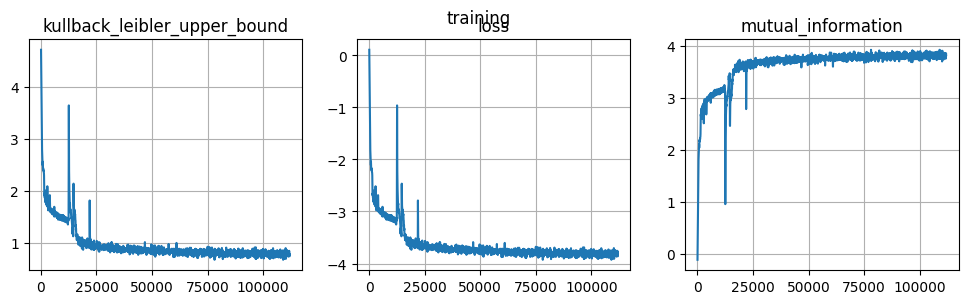

In [ ]:
history = train_infomax_embedder(
    model,
    train_dataloader,
    test_dataloader,
    device,
    callback=classification_callback,
    embedder_network_lr=config["embedder_network_lr"],
    discriminator_network_lr=config["discriminator_network_lr"],
    distribution=config["distribution"],
    n_epochs=config["n_epochs"]
)

In [ ]:
plot_embeddings(*convert_to_embeddings(embedder_network, train_dataloader, device), alpha=1, size=10, x_lim=(-3.0, 3.0), y_lim=(-3.0, 3.0))

In [ ]:
from pathlib import Path

save_results(model, config, history, experiments_path / str(config["embedding_dim"]))